# Project: No Show Appointments

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.
>
>We will explore the different attributes of the patients(Age, Neighbourhood, Gender, etc.) and see which of them have high correlation with a patient not arriving for the appointment, by asking questions like 'What is the ratio of patients receiving scholarship but not turning up for the appointment?',  'Which are the days on which higher fraction of patients don't attend their appointment' and so on.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


#### General Properties

In [3]:
df = pd.read_csv('noshow_data.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


>One important point : The no-show column has 'No' value if it is not a no-show, i.e. the patient does arrive for the appointment. It will store 'Yes' if the patient doesn't arrive for the appointment.
>
>The ScheduledDay contains timestamp data of the day on which the appoinment is booked, while the AppointmentDay contains date on which the actual appointment is.
>Since both are timestamps, it makes sense to convert them into pandas datetime objects.

In [4]:
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: datetime64[ns](2), float64(1), int64(8), object(3)
memory usage: 11.8+ MB


We see here that the total database consists of 110527 rows, and each column also has 110527 non-null values. This ensures that no Null values exist in our database.

In [5]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


We observe one anomality here. The min value for age is stated as -1, which is not possible. Let us see how many rows have that value.

In [6]:
df[df['Age']==-1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06 08:58:13,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,No


So there is only 1 row with that value. So we can just drop that row.

In [5]:
df.drop(df[df.Age==-1].index, axis=0, inplace=True )

Let us create a new column 'Day of Week' which will store the day of the week on which the appointment is to be held 

In [6]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Day of Week'] = df['AppointmentDay'].apply( lambda x : days[x.weekday()] )

<a id='eda'></a>
## Exploratory Data Analysis

### Compare mean age of patients who didn't turn up for their appointments with those who turn up

In [9]:
df[df['No-show']=='Yes']['Age'].mean()

34.31766656212196

In [10]:
df[df['No-show']=='No']['Age'].mean()

37.790504154999034

>Clearly, the mean age of patients who turn up for their appointments is more than those who don't turn up.
>
>Let us plot a histogram of the age attribute.

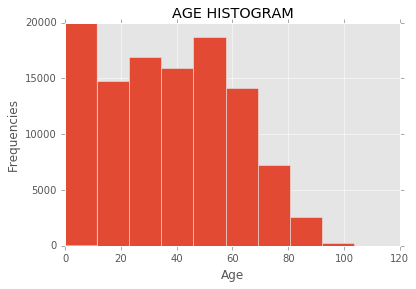

In [37]:
df['Age'].hist();
plt.title('AGE HISTOGRAM');
plt.xlabel('Age');
plt.ylabel('Frequencies');

> The number of patients in the age group 0-10 is the highest, followed by the group 45-60.
>
> Let up plot the Age vs No-show data to compare different age groups with their tendencies to skip appointments.

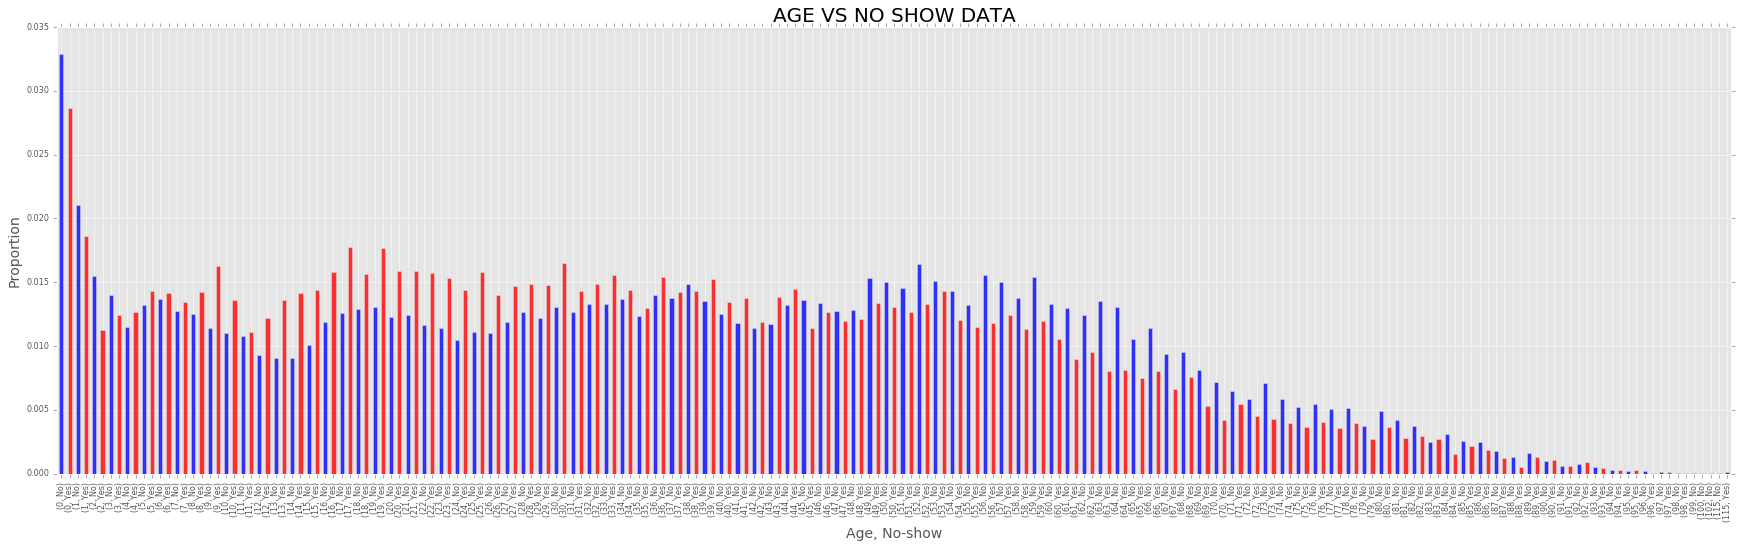

In [41]:
ages_count = df.groupby(['Age','No-show']).count()['Scholarship'] 
'''
   We are counting here for each age the number of patients who attend their appointment vs those who don't.
   Since this count value will be the same for all the columns, we can take any random attribute for the count
   values.
'''
total = df.groupby(['No-show']).count()['Scholarship']
'''
   We cannot simply plot the count values, as the number of No-shows is much lesser than patients who attend their 
   appointments and hence the bar plot will be skewed. Hence we'll find the proportion of the patients in their 
   respective categories. That will present a more uniform and accurate description of the situation.
'''
propor2 = ages_count/total
colours = ['blue','red']
propor2.plot(kind='bar', figsize=(30,8), color=colours,alpha=0.8 , fontsize=8);
plt.title('AGE VS NO SHOW DATA',size=20);
plt.xlabel('Age, No-show', size=14);
plt.ylabel('Proportion', size=14);

>In this plot, red colour is for proportion of patients that didn't turn up for their appointment, and blue for those who did. 
>
>For the age group 9-45, we see that the proportion of patients who don't turn up for their appointments is higher than those who do. The rest of the age groups have it the other way around.
>
>Plotting different bar plots for different age groups will make the difference more visible(0-30, 30-60,60+)


In [23]:
dfa = df[df['Age']<30]
x = df['Age']>=30
y = df['Age']<60
dfb = df[x & y]
dfc = df[df['Age']>=60]

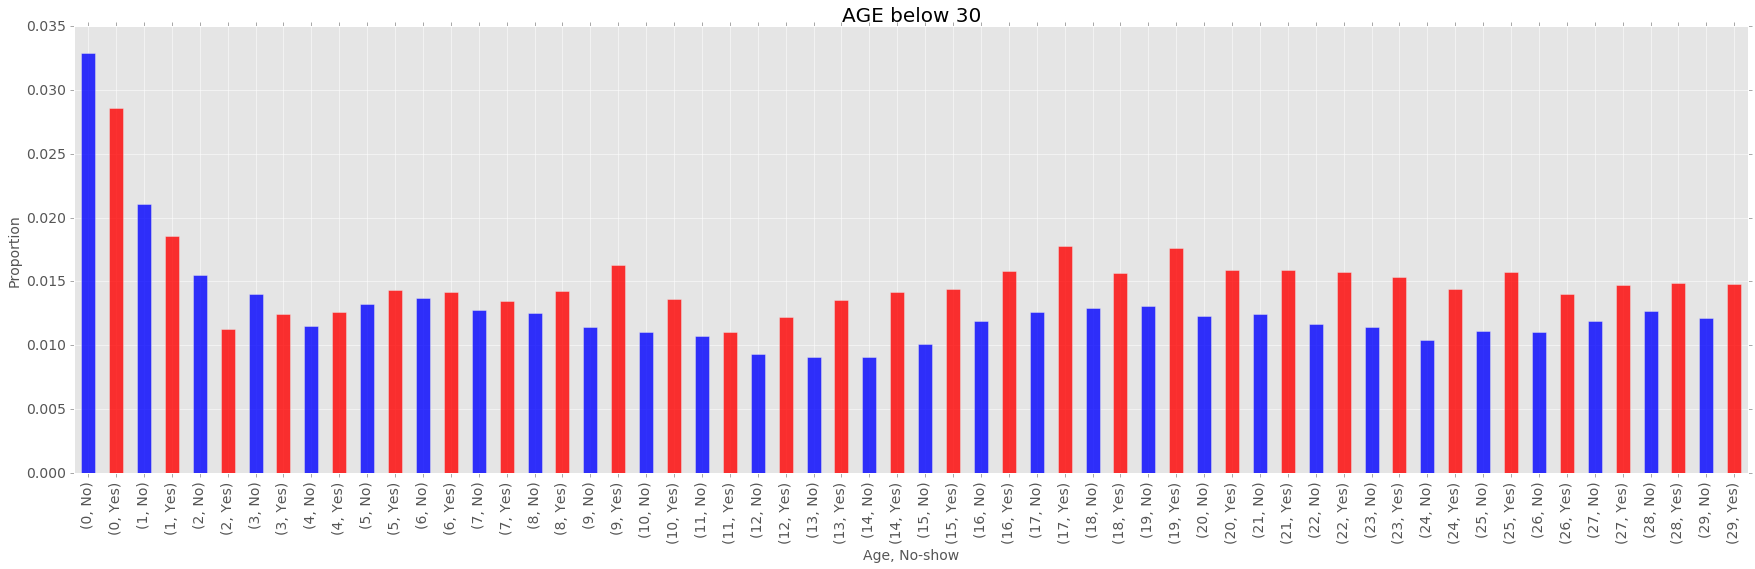

In [42]:
ages_count = dfa.groupby(['Age','No-show']).count()['Scholarship'] 
propor2 = ages_count/total
colours = ['blue','red']
propor2.plot(kind='bar', figsize=(30,8), color=colours,alpha=0.8 ,title='Age vs No-show', fontsize=14);
plt.title('AGE below 30',size=20);
plt.xlabel('Age, No-show', size=14);
plt.ylabel('Proportion', size=14);

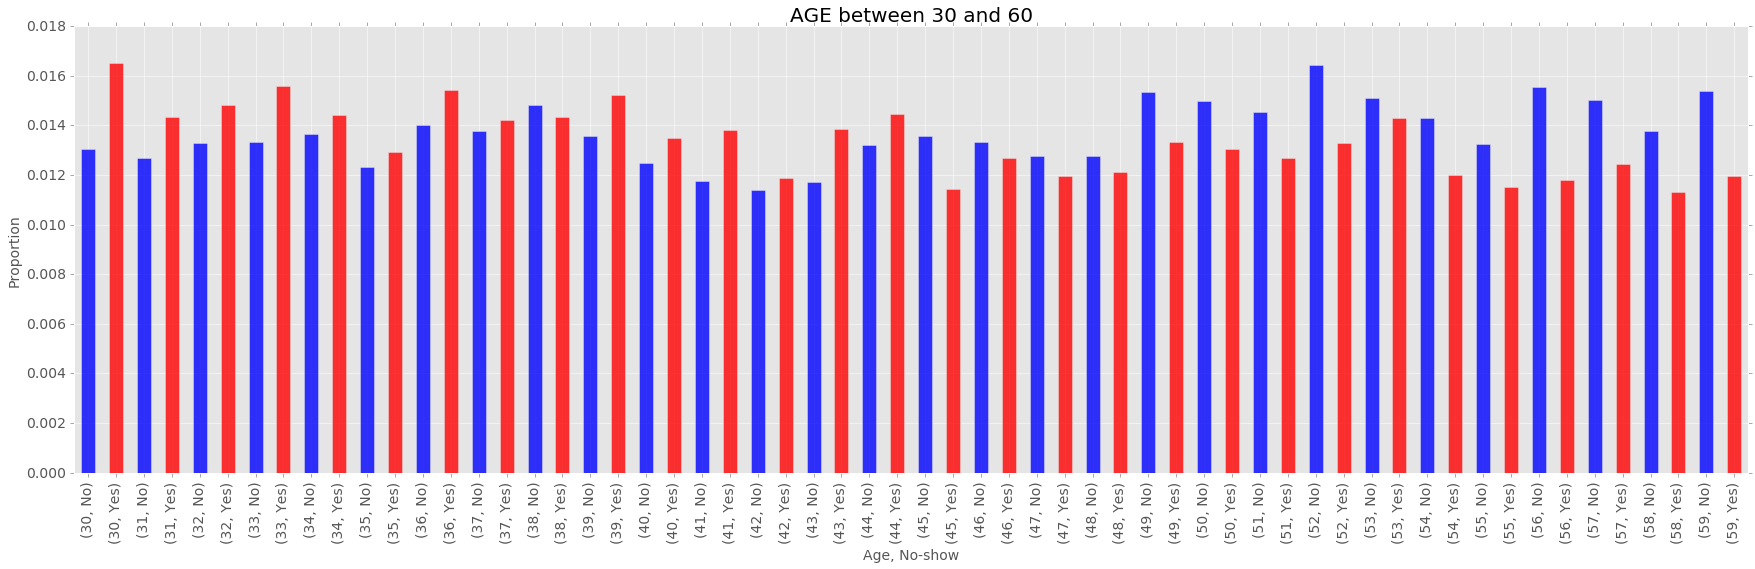

In [44]:
ages_count = dfb.groupby(['Age','No-show']).count()['Scholarship'] 
propor2 = ages_count/total
colours = ['blue','red']
propor2.plot(kind='bar', figsize=(30,8), color=colours,alpha=0.8 , fontsize=14);
plt.title('AGE between 30 and 60',size=20);
plt.xlabel('Age, No-show', size=14);
plt.ylabel('Proportion', size=14);

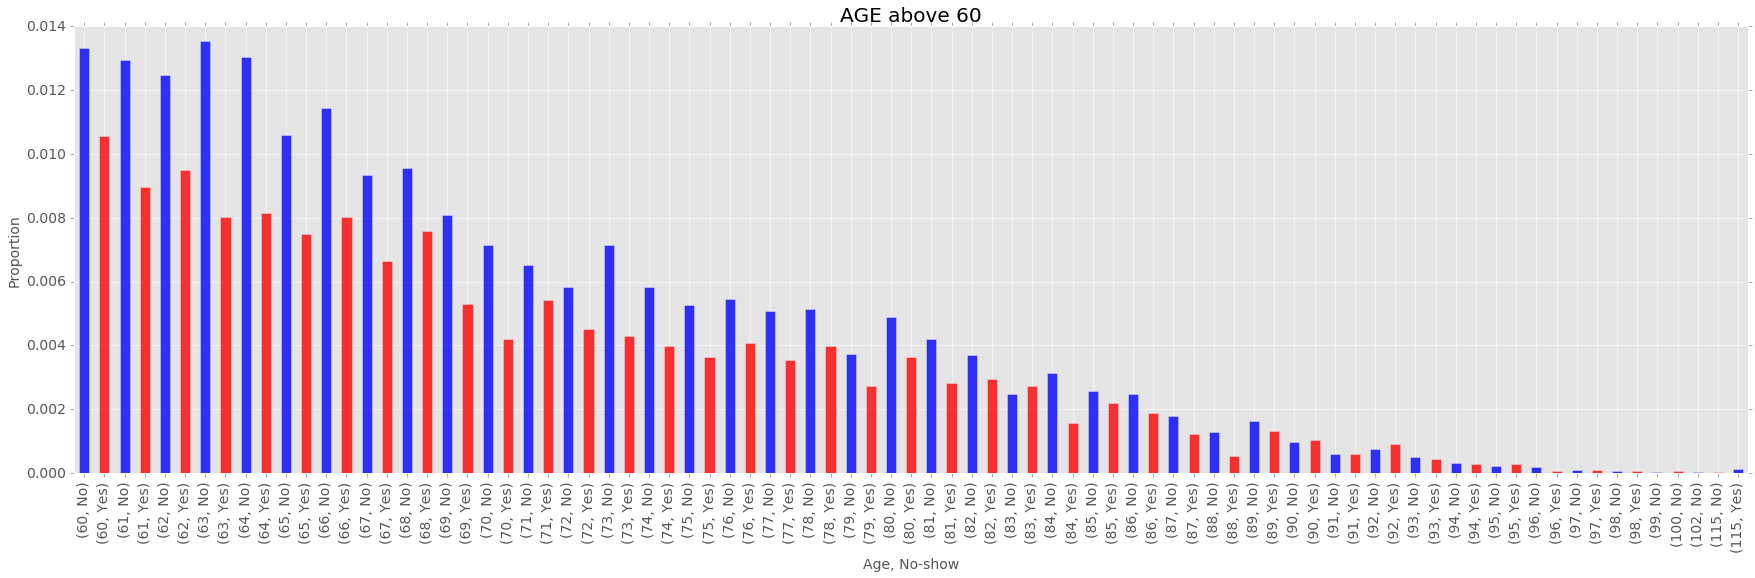

In [46]:
ages_count = dfc.groupby(['Age','No-show']).count()['Scholarship'] 
propor2 = ages_count/total
colours = ['blue','red']
propor2.plot(kind='bar', figsize=(30,8), color=colours,alpha=0.8 , fontsize=14);
plt.title('AGE above 60',size=20);
plt.xlabel('Age, No-show', size=14);
plt.ylabel('Proportion', size=14);

>In the first plot above, we see that from the age 9 the proportion of patients not turning up for their appointments is higher than those who do
>
>In the second plot, this trend is continued until the age of 44. After 44 the trend is reversed and this continues in the third plot as well.

### The relation between SMS_received and No-show

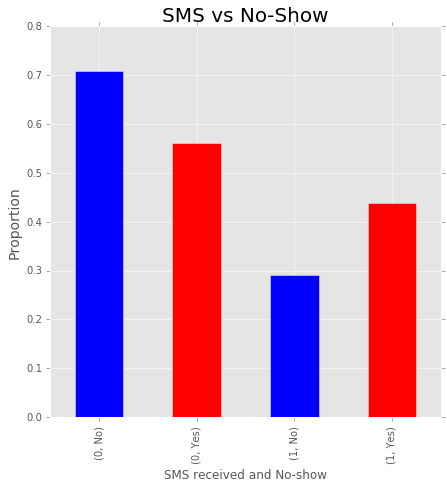

In [48]:
ax = df.groupby(['SMS_received','No-show']).count()['Scholarship']
ax = ax/total
ax.plot(kind='Bar', figsize=(7,7), color=colours);
plt.xlabel('SMS received and No-show');
plt.title('SMS vs No-Show',size=20);
plt.ylabel('Proportion', size=14);

>This plot reveals that within those patients who received SMS confirmation, there is higher proportion of patients who did not turn up for their appointment.
>
>On the other hand, of the patients who didn't receive SMS confirmation, higher proportion of patients turned up for their appoinments.
>
>Let us take it a step further and compare the genders with these results, if adding gender gives us a better insight.

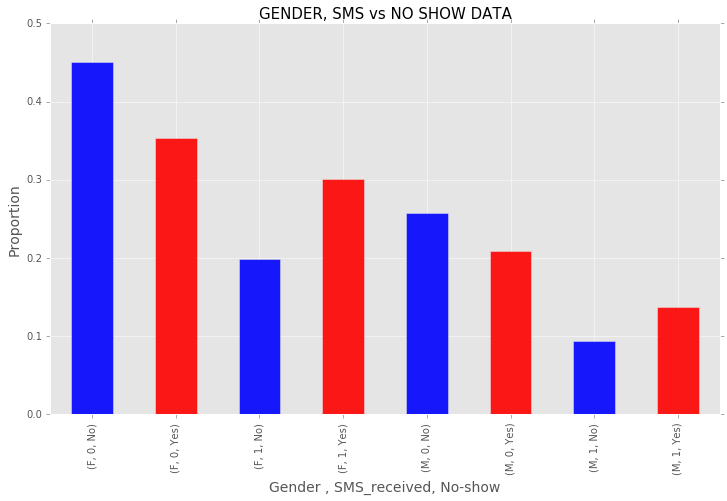

In [51]:
counts = df.groupby(['Gender','SMS_received','No-show']).count()['PatientId']
ratio = counts/total
ratio.plot(kind='bar',alpha=0.9, color=colours, figsize=(12,7));
plt.title('GENDER, SMS vs NO SHOW DATA',size=15);
plt.xlabel('Gender , SMS_received, No-show', size=14);
plt.ylabel('Proportion', size=14);

>We can see that the general trend is the same in Male or Female patients. Both have higher proportions attending their appointments upon not receiving SMS.

### Relation between day of week(appointment) and No-show

Let's plot a histogram of the days of the appointment.

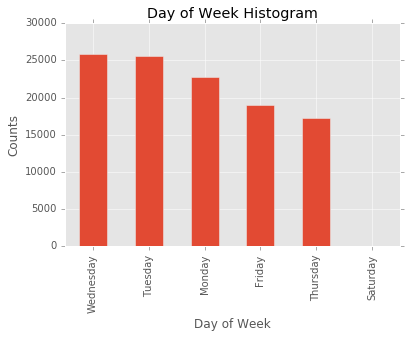

In [53]:
df['Day of Week'].value_counts().plot(kind='bar');
plt.xlabel('Day of Week');
plt.ylabel('Counts');
plt.title('Day of Week Histogram');

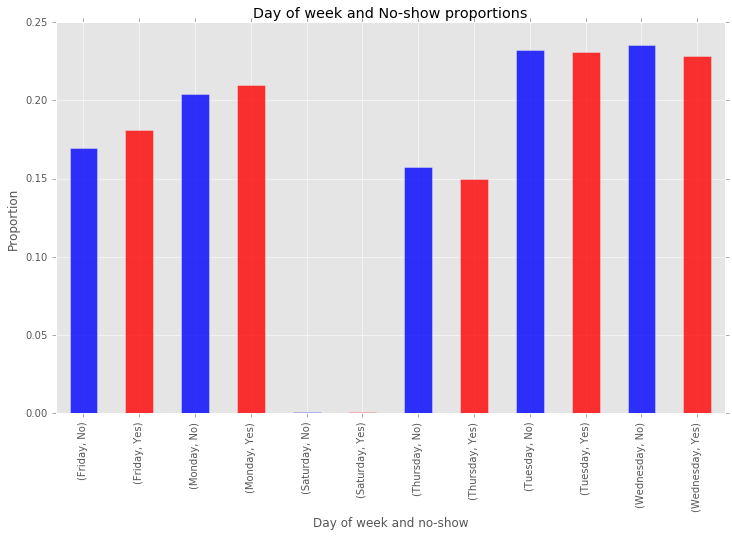

In [14]:
counts = df.groupby(['Day of Week', 'No-show']).count()['Scholarship']
propor = counts/total
propor.plot(kind='bar', title = 'Day of week and No-show proportions',alpha = 0.8, figsize=(12,7), color=colours);
plt.xlabel('Day of week and no-show');
plt.ylabel('Proportion');

>We see that on fridays and mondays, there are higher proportion of patients who don't turn up for their appointments than those who do. 
>
>On the other hand, the trend is reversed on the days of tuesday, wednesday and thursday.
>
>Let us add the gender attribute and see the changes, if any.

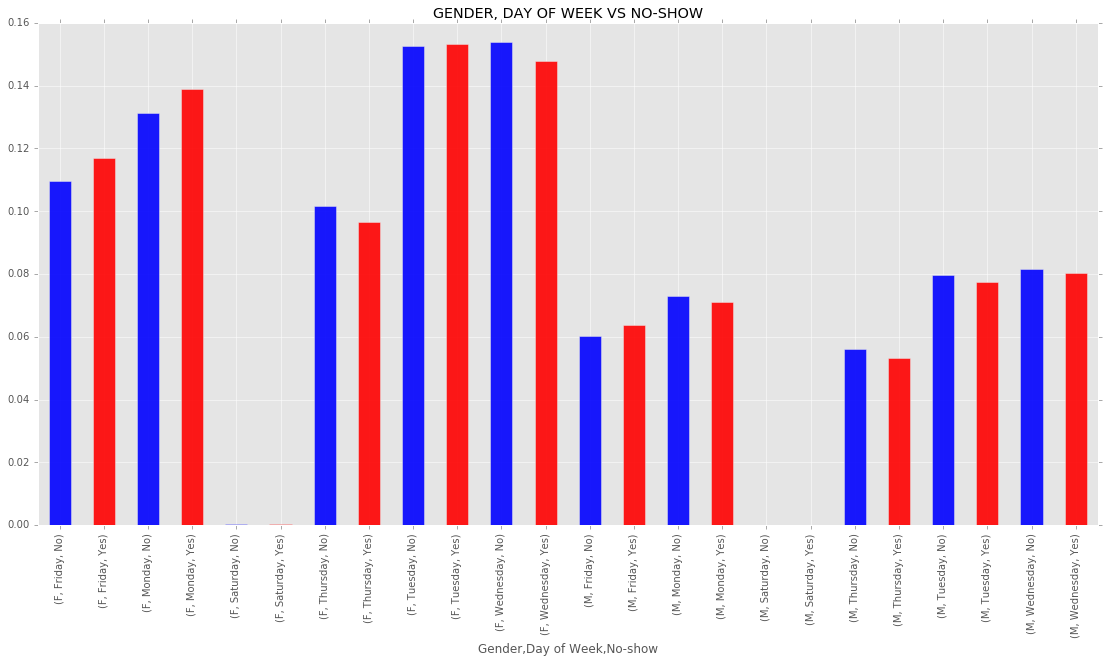

In [54]:
counts = df.groupby(['Gender','Day of Week','No-show']).count()['Scholarship']
ratio = counts/total
ratio.plot(kind='bar',alpha=0.9, color=colours, figsize=(19,9));
plt.title('GENDER, DAY OF WEEK VS NO-SHOW');

> We can see that there is a higher proportion of Male patients who turn up for their appointments on Mondays than those who don't, which is a change from the general trend. However, the general trend is carrie on on fridays in the case of Males.
>
>The general trend is the same as that of females.

### Relation between Gender, Scholarship and No-show.

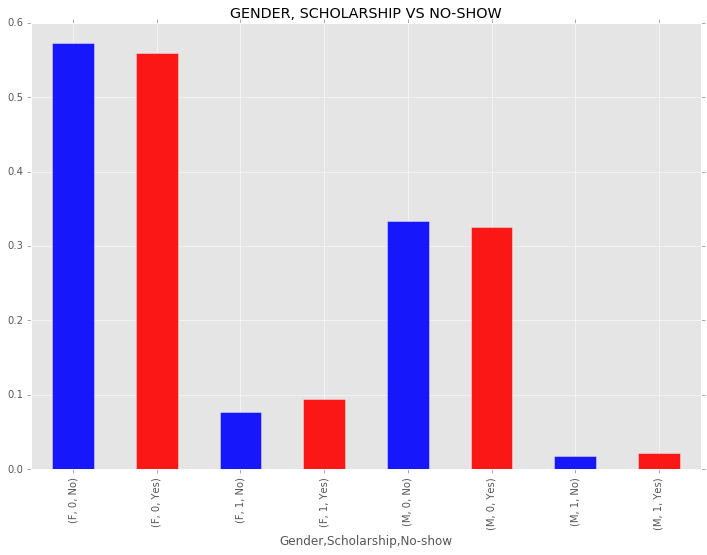

In [56]:
counts = df.groupby(['Gender','Scholarship','No-show']).count()['PatientId']
ratio = counts/total
ratio.plot(kind='bar',alpha=0.9, color=colours, figsize=(12,8));
plt.title('GENDER, SCHOLARSHIP VS NO-SHOW');

> In females, higher proportion of females turn up for their appointments who did not receive medical scholarship. While if they did receive scholarship, higher proportion of them do not turn up for their appoinments.
>
>The same trend can be observed in the males too.

### Relation between Hipertension and No-show

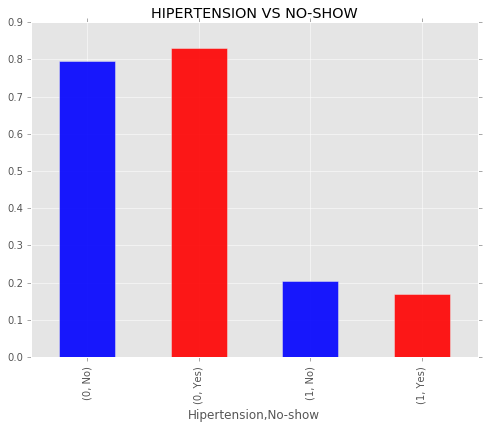

In [58]:
counts = df.groupby(['Hipertension','No-show']).count()['Scholarship']
ratio = counts/total
ratio.plot(kind='bar',alpha=0.9, color=colours, figsize=(8,6));
plt.title('HIPERTENSION VS NO-SHOW');

>We see that in patients who don't have hipertension there are higher proportion of patients who don't turn up for their appointments than those who do. 
>
>On the other hand, the trend is reversed in patients that do suffer from hipertension.
>
>Let us add the gender attribute and see the changes, if any.

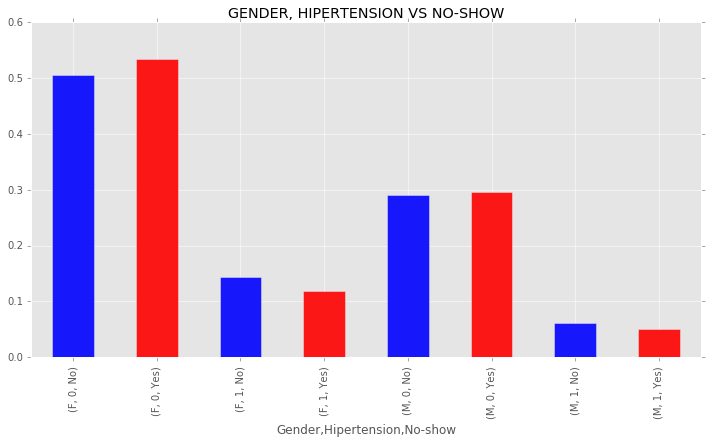

In [60]:
counts = df.groupby(['Gender','Hipertension','No-show']).count()['PatientId']
total =  df.groupby(['No-show']).count()['PatientId']
ratio = counts/total
ratio.plot(kind='bar',alpha=0.9, color=colours, figsize=(12,6));
plt.title('GENDER, HIPERTENSION VS NO-SHOW');

> We notice that this plot does not add any more information as the same trend exists in Male and Female.

# <a id='conclusions'></a>
## Conclusions

<b>Age</b> - In the age range 9-45. higher proportion of patients don't turn up for their appointments than those who do. Also, the mean age of those who don't turn up is less than those who do.

<b>SMS</b> - The ration of patients who turn up for their appoinments upon not receiving SMS is higher than those who do not turn up. In patients who did receive SMS, higher proportion of them did not turn up fpr the appointment.

<b>Day of Week</b> - Higher proportion of patients do not turn up for their appointments which are scheduled on mondays and fridays. This trend is reversed in case of Male patients on Mondays. 

<b>Scholarship</b> - Patients not having medical scholarship respect their appointments more than those who do have medical scholarship.

<b>Hipertension</b> - Patients having hipertension have higher chances of not turning up for their appointments.

> One limitation that could be stated is that there are very few neighbourhoods that have been represented in large numbers in the dataset, and the others have very few number of patients. This therefore does not accurately represent the smaller neighbourhoods, as fewer partients means lesser data about them.  
>
> The hypertension feature is somewhat inconclusive as the difference in the ratio's of No-show is very small.

## Bibliography
>Pandas Documentation
>
>Stack Overflow